# QAT with convolution and batchnorm fused constraints

本教程以Conv2D和BatchNorm的融合为例，介绍如何使用PaddleSlim接口快速为量化训练添加训练约束(constraints)。

## 1. 添加依赖

In [ ]:
import paddle
from paddle.vision.models import resnet18

from paddle.quantization import QuantConfig
from paddle.quantization.quanters import FakeQuanterWithAbsMaxObserver

from paddleslim.quant import SlimQAT
from paddleslim.quant.constraints import FreezedConvBNConstraint

## 2. 构造模型

In [ ]:
model = resnet18()

## 3. 量化训练

**配置**

构造量化配置实例，并将激活和权重的量化方式指定为基础的 AbsMax 量化策略。然后，调用 `add_constraints` 配置一个Constraints实例。
最后，使用量化配置构造SlimQAT对象。代码如下所示：

In [2]:
quanter = FakeQuanterWithAbsMaxObserver(moving_rate=0.9)
q_config = QuantConfig(activation=quanter, weight=quanter)
q_config.add_constraints(FreezedConvBNConstraint())
qat = SlimQAT(q_config)

/root/miniconda3/lib/python3.8/site-packages/paddle/nn/layer/norm.py:771: UserWarning: When training, we now always track global mean and variance.


**量化**

调用SlimQAT对象的quantize方法，将模型转为用于量化训练的模型。
用户需要指定一个inputs, 用于推断分析动态图的执行拓扑图，以便自动检测出所有Conv2D和BN的组合。


In [ ]:
x = paddle.rand([1, 3, 224, 224])
quant_model = qat.quantize(model, inplace=True, inputs=x)

在该步骤，所有的Conv2D和BN的组合，都会被替换为QuantedConv2DBatchNorm layer。在QuantedConv2DBatchNorm中，参考 [Quantizing deep convolutional networks for efficient inference: A whitepaper](https://arxiv.org/abs/1806.08342) ，在量化训练过程中模拟Conv2D和BatchNorm的融合。原理如下图所示：

<div align="center"><img src="https://user-images.githubusercontent.com/7534971/221735696-f78fdaff-2067-4a76-bb92-c99ae4740f2f.png" width="500"></div>
<div align="center">Conv BN 量化训练矫正方案示意图</div>

**查看量化训练模型结构**

直接在终端输出量化训练模型的结构，或者将模型保存到文件系统，并使用[netron](https://netron.app/)查看模型结构。
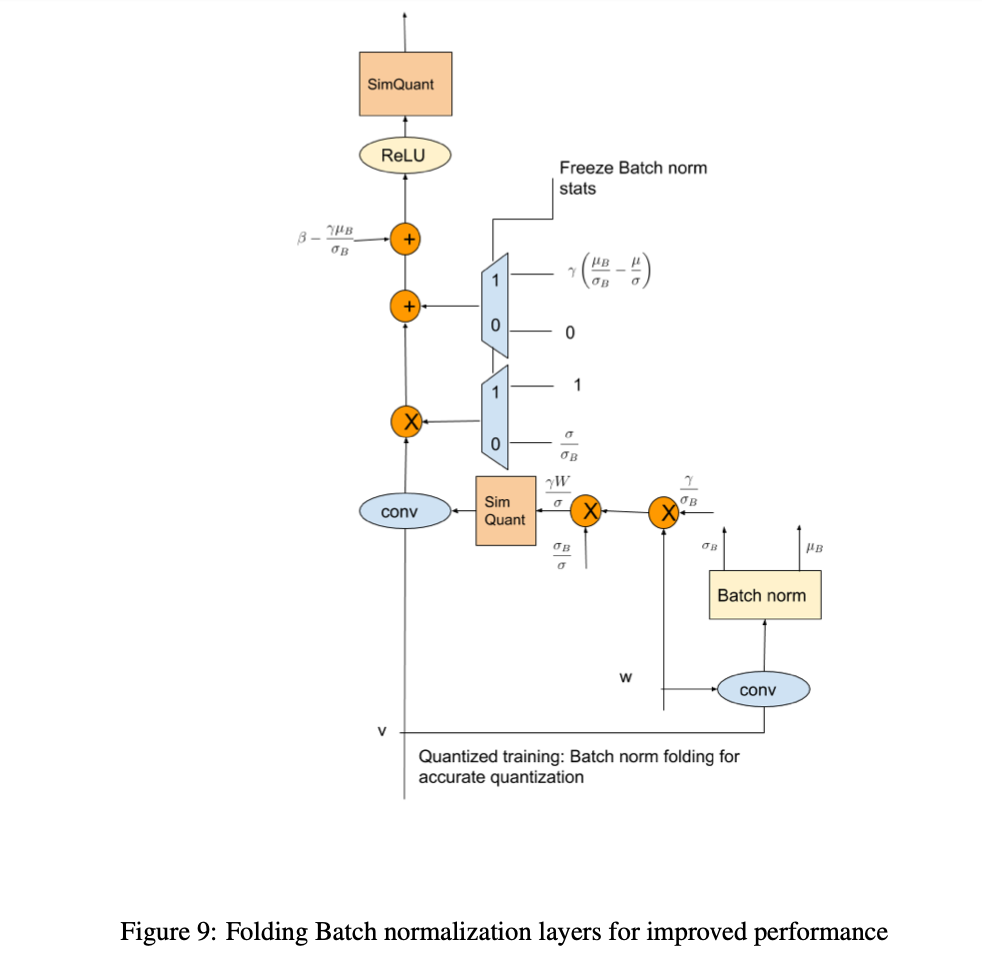

In [ ]:
print(quant_model)
paddle.jit.save(quant_model, "./qat_model", input_spec=[x])

**训练**

In [ ]:
out = quant_model(x)
out.backward()